In [3]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy

## Get GFP contact matrix

In [99]:
gfp_map = pd.read_csv("../data/gfp_1gfl_contact_matrix.txt", sep='\t', header=None)
# from https://nanohub.org/tools/contactmaps/session?sess=1404740
gfp_map.head()

,0,1,2,3,4,5,6,7,8,9,...,450,451,452,453,454,455,456,457,458,459
0,0.000000,3.805052,6.898267,9.537112,7.954587,8.981441,12.469802,12.754773,12.220778,16.024734,...,31.381256,34.720337,37.042980,40.703995,43.600613,47.219307,48.943333,51.910706,54.906273,56.462132
1,3.805052,0.000000,3.808724,6.617986,6.291074,8.114332,10.905240,11.739250,12.339651,16.044453,...,31.636324,34.768372,36.794243,40.453510,43.133621,46.744904,48.220963,51.103794,54.110416,55.470734
2,6.898267,3.808724,0.000000,3.818772,5.410528,6.373817,8.435843,10.344454,11.564447,14.889733,...,32.065071,35.096848,36.799053,40.494572,42.951889,46.609554,48.003418,50.943794,53.812569,54.929901
3,9.537112,6.617986,3.818772,0.000000,3.766714,5.287507,5.651388,7.551291,9.809889,12.672950,...,29.488104,32.356945,33.805561,37.487530,39.780857,43.437683,44.742664,47.689598,50.490269,51.483883
4,7.954587,6.291074,5.410528,3.766714,0.000000,3.795919,5.428189,5.505925,6.985375,10.364286,...,26.698008,29.764856,31.509750,35.224777,37.753578,41.433640,42.967232,45.994289,48.825912,50.047569


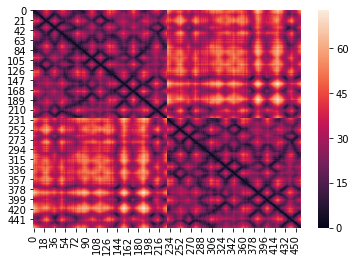

In [100]:
sns.heatmap(gfp_map)

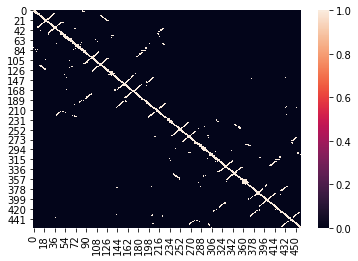

In [101]:
gfp_map_threshold = deepcopy(gfp_map)
gfp_map_threshold[gfp_map_threshold<=8] = 1  # 8 angstroms
gfp_map_threshold[gfp_map_threshold>8] = 0
sns.heatmap(gfp_map_threshold)

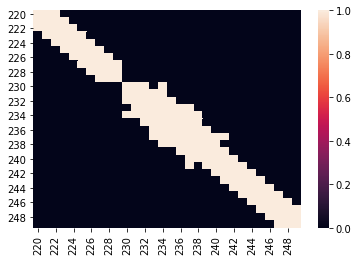

In [102]:
sns.heatmap(gfp_map_threshold.iloc[220:250,220:250])

The PDB says the last 8 residues are missing from the structure so we can safely take 1:230

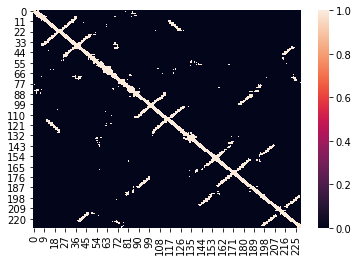

In [103]:
gfp_map_threshold = gfp_map_threshold.iloc[:230,:230]
sns.heatmap(gfp_map_threshold)

We can also apply a minimum separation distance... some papers say minimum 6 residues, others have no separation (but i and j have to be different). let's do 1

In [104]:
for i in range(gfp_map_threshold.shape[0]):
    gfp_map_threshold.iloc[i,i] = 0

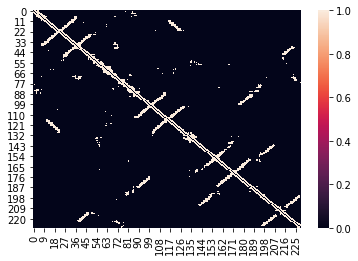

In [105]:
sns.heatmap(gfp_map_threshold)

## Additive effects
Make a linear predictor for fitness

In [4]:
fluor_data = pd.read_csv("../data/amino_acid_genotypes_to_brightness.tsv", sep='\t')
fluor_data.head()

,aaMutations,uniqueBarcodes,medianBrightness,std
0,NaN,3645,3.719212,0.106992
1,SA108D,1,1.301030,NaN
2,SA108D:SN144D:SI186V:SM231T:SL234P,1,1.301031,NaN
3,SA108D:SY141N:SH146L:SE220G,1,1.301189,NaN
4,SA108G,2,3.708478,0.020613


In [26]:
fluor_data["num_mutations"] = [len(str(x).split(':')) for x in fluor_data["aaMutations"]]
fluor_data.loc[0,"num_mutations"] = 0
fluor_data.head()

,aaMutations,uniqueBarcodes,medianBrightness,std,num_mutations
0,NaN,3645,3.719212,0.106992,0
1,SA108D,1,1.301030,NaN,1
2,SA108D:SN144D:SI186V:SM231T:SL234P,1,1.301031,NaN,5
3,SA108D:SY141N:SH146L:SE220G,1,1.301189,NaN,4
4,SA108G,2,3.708478,0.020613,1


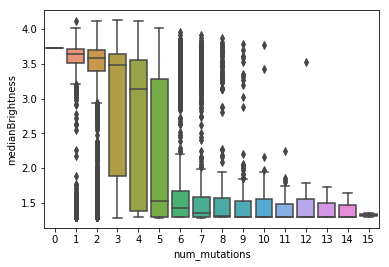

In [27]:
sns.boxplot(x="num_mutations", y="medianBrightness", data=fluor_data)

In [28]:
init_brightness = fluor_data.loc[0,"medianBrightness"]
fluor_data["delta"] = [x - init_brightness for x in fluor_data["medianBrightness"]]
fluor_data.head()

,aaMutations,uniqueBarcodes,medianBrightness,std,num_mutations,delta
0,NaN,3645,3.719212,0.106992,0,0.000000
1,SA108D,1,1.301030,NaN,1,-2.418182
2,SA108D:SN144D:SI186V:SM231T:SL234P,1,1.301031,NaN,5,-2.418181
3,SA108D:SY141N:SH146L:SE220G,1,1.301189,NaN,4,-2.418023
4,SA108G,2,3.708478,0.020613,1,-0.010734


In [30]:
single_mutations = fluor_data[fluor_data["num_mutations"] == 1]
single_mutations.head()

,aaMutations,uniqueBarcodes,medianBrightness,std,num_mutations,delta
1,SA108D,1,1.301030,NaN,1,-2.418182
4,SA108G,2,3.708478,0.020613,1,-0.010734
10,SA108S,1,3.872970,NaN,1,0.153758
17,SA108T,1,3.137392,NaN,1,-0.581820
34,SA152T,3,3.739811,0.056235,1,0.020598


/Users/bdo/miniconda3/envs/myenv2/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


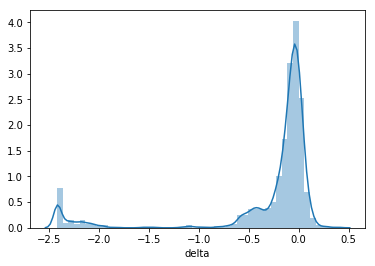

In [32]:
sns.distplot(single_mutations["delta"])

In [44]:
def predict_fluor(x):
    muts = str(x).split(':')
    total_delta = 0
    for mut in muts:
        try: total_delta += float(single_mutations[single_mutations["aaMutations"] == mut]["delta"])
        except: continue
    return total_delta

In [65]:
multiple_mutations = fluor_data[fluor_data["num_mutations"] > 1]
multiple_mutations["predicted_delta"] = [predict_fluor(x) for x in multiple_mutations["aaMutations"]]

/Users/bdo/miniconda3/envs/myenv2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [58]:
min_brightness = np.min(multiple_mutations["medianBrightness"])
max_brightness = np.max(multiple_mutations["medianBrightness"])

In [79]:
multiple_mutations["predicted_delta"] = multiple_mutations["predicted_delta"].apply(lambda x: np.max([x, min_brightness - init_brightness]))
multiple_mutations["predicted_delta"] = multiple_mutations["predicted_delta"].apply(lambda x: np.max([x, min_brightness - init_brightness]))
multiple_mutations.head()

/Users/bdo/miniconda3/envs/myenv2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/bdo/miniconda3/envs/myenv2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,aaMutations,uniqueBarcodes,medianBrightness,std,num_mutations,delta,predicted_delta
2,SA108D:SN144D:SI186V:SM231T:SL234P,1,1.301031,NaN,5,-2.418181,-2.334015
3,SA108D:SY141N:SH146L:SE220G,1,1.301189,NaN,4,-2.418023,-2.435793
5,SA108G:SK138M:SR166C:SL234P,1,3.582764,NaN,4,-0.136448,0.024931
6,SA108G:SK154E:SF163S:SL192Q:SL193P,1,1.499573,NaN,5,-2.219639,-0.418420
7,SA108G:SK156R,1,3.659013,NaN,2,-0.060199,0.028447


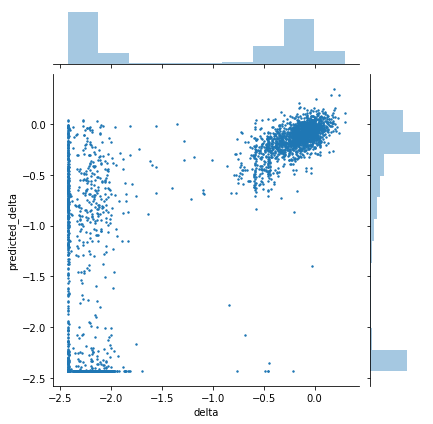

In [92]:
sns.jointplot(x="delta", y="predicted_delta", data=multiple_mutations.sample(3000), joint_kws={"s": 2})

In [85]:
from scipy import stats
stats.spearmanr(multiple_mutations["delta"], multiple_mutations["predicted_delta"])

SpearmanrResult(correlation=0.8111702873668961, pvalue=0.0)

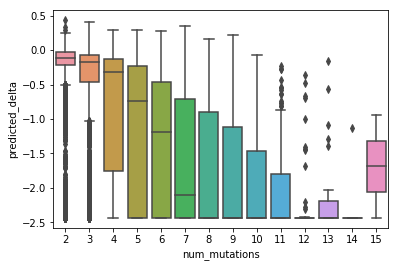

In [93]:
sns.boxplot(x="num_mutations", y="predicted_delta", data=multiple_mutations)

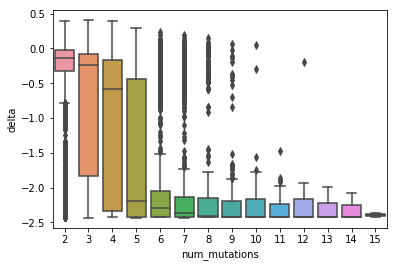

In [94]:
sns.boxplot(x="num_mutations", y="delta", data=multiple_mutations)

Using single mutation data improves prediction of fitness as compared to just the number of mutations, but it is not great.

## Pairwise effects
Here we first attempt to explain pairwise mutation data using the contact matrix and contact scores. 

/Users/bdo/miniconda3/envs/myenv2/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


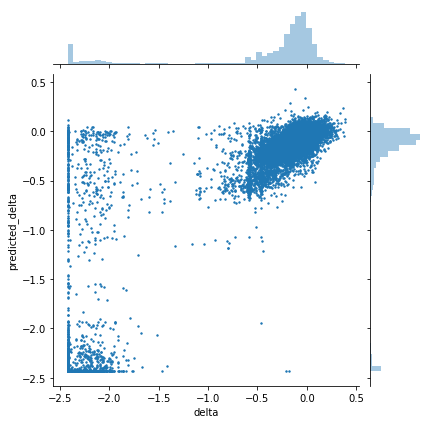

In [95]:
two_mutations = multiple_mutations[multiple_mutations["num_mutations"] == 2]
sns.jointplot(x="delta", y="predicted_delta", data=two_mutations, joint_kws={"s": 2})

In [152]:
stats.pearsonr(two_mutations["delta"], two_mutations["predicted_delta"])

(0.8410779859795008, 0.0)

In [97]:
# from https://github.com/Zsailer/latticeproteins/blob/master/latticeproteins/interactions.py
miyazawa_jernigan = {
'CC':-5.44, 'CM':-5.05, 'CF':-5.63, 'CI':-5.03, 'CL':-5.03, 'CV':-4.46, 'CW':-4.76, 'CY':-3.89, 'CA':-3.38, 'CG':-3.16, 'CT':-2.88, 'CS':-2.86, 'CQ':-2.73, 'CN':-2.59, 'CE':-2.08, 'CD':-2.66, 'CH':-3.63, 'CR':-2.70, 'CK':-1.54, 'CP':-2.92,
'MC':-5.05, 'MM':-6.06, 'MF':-6.68, 'MI':-6.33, 'ML':-6.01, 'MV':-5.52, 'MW':-6.37, 'MY':-4.92, 'MA':-3.99, 'MG':-3.75, 'MT':-3.73, 'MS':-3.55, 'MQ':-3.17, 'MN':-3.50, 'ME':-3.19, 'MD':-2.90, 'MH':-3.31, 'MR':-3.49, 'MK':-3.11, 'MP':-4.11,
'FC':-5.63, 'FM':-6.68, 'FF':-6.85, 'FI':-6.39, 'FL':-6.26, 'FV':-5.75, 'FW':-6.02, 'FY':-4.95, 'FA':-4.36, 'FG':-3.72, 'FT':-3.76, 'FS':-3.56, 'FQ':-3.30, 'FN':-3.55, 'FE':-3.51, 'FD':-3.31, 'FH':-4.61, 'FR':-3.54, 'FK':-2.83, 'FP':-3.73,
'IC':-5.03, 'IM':-6.33, 'IF':-6.39, 'II':-6.22, 'IL':-6.17, 'IV':-5.58, 'IW':-5.64, 'IY':-4.63, 'IA':-4.41, 'IG':-3.65, 'IT':-3.74, 'IS':-3.43, 'IQ':-3.22, 'IN':-2.99, 'IE':-3.23, 'ID':-2.91, 'IH':-3.76, 'IR':-3.33, 'IK':-2.70, 'IP':-3.47,
'LC':-5.03, 'LM':-6.01, 'LF':-6.26, 'LI':-6.17, 'LL':-5.79, 'LV':-5.38, 'LW':-5.50, 'LY':-4.26, 'LA':-3.96, 'LG':-3.43, 'LT':-3.43, 'LS':-3.16, 'LQ':-3.09, 'LN':-2.99, 'LE':-2.91, 'LD':-2.59, 'LH':-3.84, 'LR':-3.15, 'LK':-2.63, 'LP':-3.06,
'VC':-4.46, 'VM':-5.52, 'VF':-5.75, 'VI':-5.58, 'VL':-5.38, 'VV':-4.94, 'VW':-5.05, 'VY':-4.05, 'VA':-3.62, 'VG':-3.06, 'VT':-2.95, 'VS':-2.79, 'VQ':-2.67, 'VN':-2.36, 'VE':-2.56, 'VD':-2.25, 'VH':-3.38, 'VR':-2.78, 'VK':-1.95, 'VP':-2.96,
'WC':-4.76, 'WM':-6.37, 'WF':-6.02, 'WI':-5.64, 'WL':-5.50, 'WV':-5.05, 'WW':-5.42, 'WY':-4.44, 'WA':-3.93, 'WG':-3.37, 'WT':-3.31, 'WS':-2.95, 'WQ':-3.16, 'WN':-3.11, 'WE':-2.94, 'WD':-2.91, 'WH':-4.02, 'WR':-3.56, 'WK':-2.49, 'WP':-3.66,
'YC':-3.89, 'YM':-4.92, 'YF':-4.95, 'YI':-4.63, 'YL':-4.26, 'YV':-4.05, 'YW':-4.44, 'YY':-3.55, 'YA':-2.85, 'YG':-2.50, 'YT':-2.48, 'YS':-2.30, 'YQ':-2.53, 'YN':-2.47, 'YE':-2.42, 'YD':-2.25, 'YH':-3.33, 'YR':-2.75, 'YK':-2.01, 'YP':-2.80,
'AC':-3.38, 'AM':-3.99, 'AF':-4.36, 'AI':-4.41, 'AL':-3.96, 'AV':-3.62, 'AW':-3.93, 'AY':-2.85, 'AA':-2.51, 'AG':-2.15, 'AT':-2.15, 'AS':-1.89, 'AQ':-1.70, 'AN':-1.44, 'AE':-1.51, 'AD':-1.57, 'AH':-2.09, 'AR':-1.50, 'AK':-1.10, 'AP':-1.81,
'GC':-3.16, 'GM':-3.75, 'GF':-3.72, 'GI':-3.65, 'GL':-3.43, 'GV':-3.06, 'GW':-3.37, 'GY':-2.50, 'GA':-2.15, 'GG':-2.17, 'GT':-2.03, 'GS':-1.70, 'GQ':-1.54, 'GN':-1.56, 'GE':-1.22, 'GD':-1.62, 'GH':-1.94, 'GR':-1.68, 'GK':-0.84, 'GP':-1.72,
'TC':-2.88, 'TM':-3.73, 'TF':-3.76, 'TI':-3.74, 'TL':-3.43, 'TV':-2.95, 'TW':-3.31, 'TY':-2.48, 'TA':-2.15, 'TG':-2.03, 'TT':-1.72, 'TS':-1.59, 'TQ':-1.59, 'TN':-1.51, 'TE':-1.45, 'TD':-1.66, 'TH':-2.31, 'TR':-1.97, 'TK':-1.02, 'TP':-1.66,
'SC':-2.86, 'SM':-3.55, 'SF':-3.56, 'SI':-3.43, 'SL':-3.16, 'SV':-2.79, 'SW':-2.95, 'SY':-2.30, 'SA':-1.89, 'SG':-1.70, 'ST':-1.59, 'SS':-1.48, 'SQ':-1.37, 'SN':-1.31, 'SE':-1.48, 'SD':-1.46, 'SH':-1.94, 'SR':-1.22, 'SK':-0.83, 'SP':-1.35,
'QC':-2.73, 'QM':-3.17, 'QF':-3.30, 'QI':-3.22, 'QL':-3.09, 'QV':-2.67, 'QW':-3.16, 'QY':-2.53, 'QA':-1.70, 'QG':-1.54, 'QT':-1.59, 'QS':-1.37, 'QQ':-0.89, 'QN':-1.36, 'QE':-1.33, 'QD':-1.26, 'QH':-1.85, 'QR':-1.85, 'QK':-1.02, 'QP':-1.73,
'NC':-2.59, 'NM':-3.50, 'NF':-3.55, 'NI':-2.99, 'NL':-2.99, 'NV':-2.36, 'NW':-3.11, 'NY':-2.47, 'NA':-1.44, 'NG':-1.56, 'NT':-1.51, 'NS':-1.31, 'NQ':-1.36, 'NN':-1.59, 'NE':-1.43, 'ND':-1.33, 'NH':-2.01, 'NR':-1.41, 'NK':-0.91, 'NP':-1.43,
'EC':-2.08, 'EM':-3.19, 'EF':-3.51, 'EI':-3.23, 'EL':-2.91, 'EV':-2.56, 'EW':-2.94, 'EY':-2.42, 'EA':-1.51, 'EG':-1.22, 'ET':-1.45, 'ES':-1.48, 'EQ':-1.33, 'EN':-1.43, 'EE':-1.18, 'ED':-1.23, 'EH':-2.27, 'ER':-2.07, 'EK':-1.60, 'EP':-1.40,
'DC':-2.66, 'DM':-2.90, 'DF':-3.31, 'DI':-2.91, 'DL':-2.59, 'DV':-2.25, 'DW':-2.91, 'DY':-2.25, 'DA':-1.57, 'DG':-1.62, 'DT':-1.66, 'DS':-1.46, 'DQ':-1.26, 'DN':-1.33, 'DE':-1.23, 'DD':-0.96, 'DH':-2.14, 'DR':-1.98, 'DK':-1.32, 'DP':-1.19,
'HC':-3.63, 'HM':-3.31, 'HF':-4.61, 'HI':-3.76, 'HL':-3.84, 'HV':-3.38, 'HW':-4.02, 'HY':-3.33, 'HA':-2.09, 'HG':-1.94, 'HT':-2.31, 'HS':-1.94, 'HQ':-1.85, 'HN':-2.01, 'HE':-2.27, 'HD':-2.14, 'HH':-2.78, 'HR':-2.12, 'HK':-1.09, 'HP':-2.17,
'RC':-2.70, 'RM':-3.49, 'RF':-3.54, 'RI':-3.33, 'RL':-3.15, 'RV':-2.78, 'RW':-3.56, 'RY':-2.75, 'RA':-1.50, 'RG':-1.68, 'RT':-1.97, 'RS':-1.22, 'RQ':-1.85, 'RN':-1.41, 'RE':-2.07, 'RD':-1.98, 'RH':-2.12, 'RR':-1.39, 'RK':-0.06, 'RP':-1.85,
'KC':-1.54, 'KM':-3.11, 'KF':-2.83, 'KI':-2.70, 'KL':-2.63, 'KV':-1.95, 'KW':-2.49, 'KY':-2.01, 'KA':-1.10, 'KG':-0.84, 'KT':-1.02, 'KS':-0.83, 'KQ':-1.02, 'KN':-0.91, 'KE':-1.60, 'KD':-1.32, 'KH':-1.09, 'KR':-0.06, 'KK':0.13, 'KP':-0.67,
'PC':-2.92, 'PM':-4.11, 'PF':-3.73, 'PI':-3.47, 'PL':-3.06, 'PV':-2.96, 'PW':-3.66, 'PY':-2.80, 'PA':-1.81, 'PG':-1.72, 'PT':-1.66, 'PS':-1.35, 'PQ':-1.73, 'PN':-1.43, 'PE':-1.40, 'PD':-1.19, 'PH':-2.17, 'PR':-1.85, 'PK':-0.67, 'PP':-1.18}

In [98]:
gfp_seq = list("MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTL\
VTTFSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLV\
NRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLAD\
HYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK")
# https://www.uniprot.org/uniprot/P42212.fasta

In [106]:
two_mutations.head()

,aaMutations,uniqueBarcodes,medianBrightness,std,num_mutations,delta,predicted_delta
7,SA108G:SK156R,1,3.659013,NaN,2,-0.060199,0.028447
12,SA108S:SE130G,1,3.767735,NaN,2,0.048523,0.076134
15,SA108S:SN144D,1,3.631026,NaN,2,-0.088186,0.143170
18,SA108T:SI150V,1,2.633845,NaN,2,-1.085367,-0.605767
25,SA108V:SI150V,1,1.450932,NaN,2,-2.268280,-0.023947


In [124]:
def get_energy(aa1, aa2):
    return miyazawa_jernigan[''.join([aa1, aa2])]

def predict_pairwise_energy_chg(mutations):
    mutations = mutations.split(':')
    
    old_total = 0
    new_total = 0
    for mutation in mutations:
        if '*' in mutation: continue  # not going to predict stop codon mutations
        old_aa = list(mutation)[1]
        new_aa = list(mutation)[-1]
        pos = int(''.join(list(mutation)[2:-1]))  # remember this is 1-indexed
        if pos > gfp_map_threshold.shape[0] - 1: continue  # not going to predict mutations that aren't part of the seq
        # print(old_aa, new_aa, pos)
        
        # get all interactions -- the gfp map is 0-indexed
        interactions = gfp_map_threshold[pos-1]
        for i in range(len(interactions)):
            if interactions[i] == 0: continue
            
            gfp_aa = gfp_seq[i]
            old_total += get_energy(old_aa, gfp_aa)
            new_total += get_energy(new_aa, gfp_aa)
        
    return new_total - old_total  # difference between old and new energies

In [125]:
two_mutations["pairwise_energy_chg"] = [predict_pairwise_energy_chg(x) for x in two_mutations["aaMutations"]]
two_mutations.head()

/Users/bdo/miniconda3/envs/myenv2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,aaMutations,uniqueBarcodes,medianBrightness,std,num_mutations,delta,predicted_delta,predicted_delta_pairwise,pairwise_energy_chg
7,SA108G:SK156R,1,3.659013,NaN,2,-0.060199,0.028447,-1.43,-1.43
12,SA108S:SE130G,1,3.767735,NaN,2,0.048523,0.076134,0.53,0.53
15,SA108S:SN144D,1,3.631026,NaN,2,-0.088186,0.143170,7.08,7.08
18,SA108T:SI150V,1,2.633845,NaN,2,-1.085367,-0.605767,9.18,9.18
25,SA108V:SI150V,1,1.450932,NaN,2,-2.268280,-0.023947,-6.89,-6.89


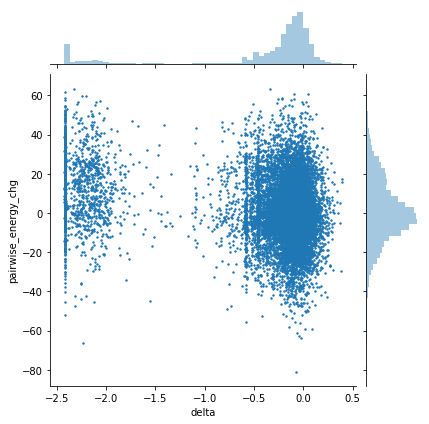

In [126]:
sns.jointplot(x="delta", y="pairwise_energy_chg", data=two_mutations, joint_kws={"s": 2})

This makes sense because proteins with a positive contribution to free energy from pairwise interactions are more likely to be less fit.

In [127]:
import statsmodels.api as sm

In [157]:
Y = two_mutations["delta"]
X = two_mutations[["predicted_delta", "pairwise_energy_chg"]]
#X = two_mutations["predicted_delta"]


model = sm.OLS(Y,X)

In [158]:
results = model.fit()
preds = results.predict(X)

/Users/bdo/miniconda3/envs/myenv2/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


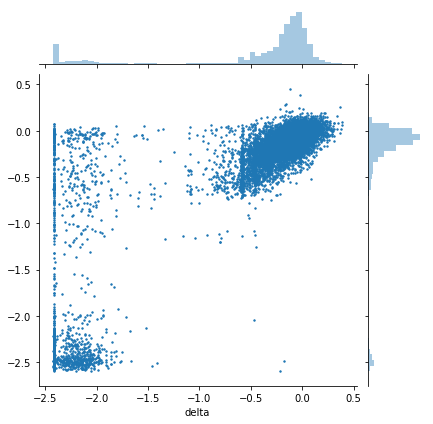

In [159]:
sns.jointplot(x=two_mutations["delta"], y=preds, joint_kws={"s": 2})

In [160]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  delta   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                 2.131e+04
Date:                Sat, 24 Nov 2018   Prob (F-statistic):               0.00
Time:                        00:59:35   Log-Likelihood:                -6068.5
No. Observations:               13010   AIC:                         1.214e+04
Df Residuals:                   13008   BIC:                         1.216e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
predicted_delta         1.0165      0.005    197.064      0.000       1.006       1.027
pairwise_energy_chg    -0.0020      0.000     -9.505      0.000      -0.002      -0.002
==============================================================================
Omnibus:                    10511.249   Durbin-Watson:                   1.451
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           215276.335
Skew:                          -3.901   Prob(JB):                         0.00
Kurtosis:                      21.337   Cond. No.                         25.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [161]:
preds[preds < min_brightness - init_brightness] = min_brightness - init_brightness
stats.pearsonr(two_mutations["delta"], preds)

(0.843703024934761, 0.0)

The addition of pairwise MJ scores barely improves the model (R-squared increases by 0.001). Am I calculating it correctly